In [1]:
import sys
sys.path.append('../source')
import os
import numpy as np
import pandas as pd
import random
import json
import earthaccess
from utils import *
from data import *

**Required Funcs**

In [2]:
def generate_lst_dataset(
    images: list, 
    masks: list, 
    patch_size: tuple, 
    save_path: str,
    skip_mask = False, 
    image_filter = None,
    mask_filter = None,
    limit=5000
    ):
    """Generates LST dataset by retiling images masks. Masks are named by originalname_r_c

    Args:
        images (list): hdf images to retile
        masks (list): hdf masks to retile
        patch_size (tuple): size of patches
        image_filter (function): function returning a filtered list of images
        mask_filter (function): function returning a filtered list of masks
        save_path (str): directory to save images and masked images
        limit (int, optional): set limit of images to save. Defaults to 5000.
    """
    collection = pd.DataFrame(columns=['sample', 'ground_truth'])
    
    # Create LST tiles from hdf files
    lst_tiles = {}
    for image in images:
        basename = os.path.splitext(os.path.basename(image))[0]
        lst = get_lst_day(image)
        tiles_temp = retile_and_name(lst, basename, patch_size)
        if image_filter is not None:
            tiles_temp = image_filter(tiles_temp)
        lst_tiles = {**lst_tiles, **tiles_temp}
    print('# of LST tiles: {}'.format(len(lst_tiles)))
        
    assert len(os.listdir(save_path)) == 0, 'Save path not empty'
    
    # Create paths for ground_truth
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(os.path.join(save_path, 'ground_truth')):
        os.makedirs(os.path.join(save_path, 'ground_truth'))
    
    # Generate ground truth
    for image_name, image in lst_tiles.items():
        image_filename = image_name + '.npy'
        np.save(os.path.join(save_path, 'ground_truth', image_filename), image)
        if skip_mask:
            collection.loc[len(collection.index)] = [ 
                image_filename,
                image_filename,
            ]      

    if skip_mask:
        return

    # Make directories for masked images and masks, then creates masks and applies over 
    # ground truth images
    if not os.path.exists(os.path.join(save_path, 'masked_images')):
        os.makedirs(os.path.join(save_path, 'masked_images'))
    if not os.path.exists(os.path.join(save_path, 'masks')):
        os.makedirs(os.path.join(save_path, 'masks'))
    
    # Creates masks
    mask_tiles = {}
    for mask in masks:
        basename = os.path.splitext(os.path.basename(mask))[0]
        mask = get_cloud_mask(mask)
        tiles_temp = retile_and_name(mask, basename, patch_size)
        if mask_filter is not None:
            tiles_temp = mask_filter(tiles_temp)
        mask_tiles = {**mask_tiles, **tiles_temp}
    print('# of mask tiles: {}'.format(len(mask_tiles)))

    assert len(mask_tiles) * len(lst_tiles) <= limit, 'Limit Exceeded ({} total images)'.format(len(mask_tiles) * len(lst_tiles))
    assert len(mask_tiles) > 0 and len(lst_tiles) > 0, 'Either masks or images are empty'   

    # Iterate through each image tile and apply mask, then save to ground_truth
    for image_name, image in lst_tiles.items():
        image_filename = image_name + '.npy'
        for mask_name, mask in mask_tiles.items():
            # Save masks
            if not os.path.exists(os.path.join(save_path, 'masks', mask_name + 'npy')):
                np.save(os.path.join(save_path, 'masks', mask_name + 'npy'), mask)
                
            masked_lst = np.multiply(image, mask)
            masked_lst_filename = mask_name + '_' + image_name + '.npy'
            # ADD ASSERTIONS HERE

            # Save masked images 
            np.save(os.path.join(save_path, 'masked_images', masked_lst_filename), masked_lst)

            # Log pair of masked images and original image to collection
            collection.loc[len(collection.index)] = [ 
                masked_lst_filename,
                image_filename,
            ]      
    assert len(collection) == len(os.listdir(os.path.join(save_path, 'masked_images')))
    
    # Save collection to collection.csv in save_path
    collection.to_csv(os.path.join(save_path, 'collection.csv'), index=False)
    print('Sample pairs created: {}'.format(len(collection)))

In [3]:
def mask_filter(images: dict, range: tuple, no_keys: int = -1):
    """Filter for masks based on percent cloud coverage and sets upper limit of masks to generate
    from a set of images

    Args:
        images (dict): dict of images (filepath and numpy array)
        range (tuple): tolerated cloud coverage (lower, upper) in range 0 to 1
        no_keys (int, optional): amount of masks to generate from dict, defaults to all

    Returns:
        _type_: dict of masks of length no_keys (filepath and numpy array)
    """
    for key, img in images.copy().items(): 
        if get_percent_coverage(img) < range[0] or get_percent_coverage(img) > range[1]:
            del images[key]
   
    keys = images.keys()
    
    if no_keys > 0 and no_keys < len(keys):
        keys = random.sample(sorted(images.keys()), no_keys)
        
    return {k: images[k] for k in keys}

# def image_filter(images: dict, no_keys=-1):
#     for key, img in images.copy().items(): 
#         if get_percent_coverage(img) != 0:
#             del images[key]
   
#     keys = images.keys()
    
#     if no_keys > 0 and no_keys < len(keys):
#         keys = random.sample(sorted(images.keys()), no_keys)
        
#     return {k: images[k] for k in keys}

**Download and Generate Images**

In [ ]:
date_range = ("2020-01-01", "2024-12-31")
bounding_box = (-109.668974, 43.898328, -108.548975, 44.07322)
cloud_cover = (0, 4)
count = 8
save_path = os.path.join('../../data', 'set-{}-{}'.format(cloud_cover[0], cloud_cover[1]))

query_modis(
    date_range=date_range,
    bounding_box=bounding_box,
    cloud_cover=cloud_cover,
    count=count,
    path=save_path,
)

**Create Dataset**

In [4]:
data_path = '../../data/'
img_path = os.path.join(data_path, 'set-0-4/raw')
mask_path = os.path.join(data_path, 'set-5-25/raw')
samples = [os.path.join(img_path, x) for x in os.listdir(img_path)]
masks = [os.path.join(mask_path, x) for x in os.listdir(mask_path)]

In [5]:
print('# of samples: {}\n# of masks: {}'.format(len(samples), len(masks)))

# of samples: 8
# of masks: 50


In [19]:
bins = (0.1, 0.25)
save_path = os.path.join(data_path, 'LST-{}-{}'.format(int(bins[0]*100), int(bins[1]*100)))

generate_lst_dataset(
    images=samples, 
    masks=masks, 
    patch_size=(32, 32), 
    image_filter=lambda x: mask_filter(x, (0, 0), 3),
    mask_filter=lambda x: mask_filter(x, (bins[0], bins[1]), 5),
    save_path=save_path,
    skip_mask=False,
    limit=6000
)

with open(os.path.join(save_path, 'info.json'), 'w') as outfile: 
    json.dump({'samples': str(samples), 'masks': str(masks)}, outfile)

# of LST tiles: 24
# of mask tiles: 243
Sample pairs created: 5832


**Dataset Vis**

In [24]:
import sys
sys.path.append('../source')
from data import *
from utils import*
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [25]:
data_root = '../../data/LST-5-10/'
dataset = LSTDataset(
    data_path=os.path.join(data_root, 'ground_truth'), 
    mask_path=os.path.join(data_root, 'masked_images'),
    collection_path=os.path.join(data_root, 'collection.csv')
    )

Text(0.5, 1.0, 'Sample')

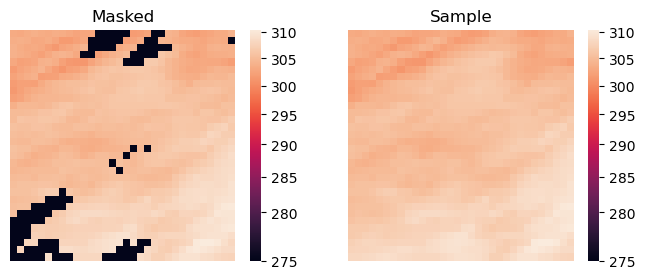

In [31]:
masked, sample = dataset[np.random.randint(len(dataset))]
cmap = sns.color_palette(
    'rocket', as_cmap=True
)
norm = colors.PowerNorm(gamma=0.8, vmin = 275, vmax=np.max(sample))

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(masked, ax=axs[0], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[0].set_title('Masked')

sns.heatmap(sample, ax=axs[1], cmap=cmap, norm=norm, xticklabels=False, yticklabels=False)
axs[1].set_title('Sample')
